In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [94]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [95]:
df = pd.read_csv('../data/clean_transactions_data.csv')

In [96]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['PreviousTransactionDate'] = pd.to_datetime(df['PreviousTransactionDate'])

In [97]:
df['Hour'] = df['TransactionDate'].dt.hour
df['Day'] = df['TransactionDate'].dt.day
df['DayOfWeek'] = df['TransactionDate'].dt.dayofweek

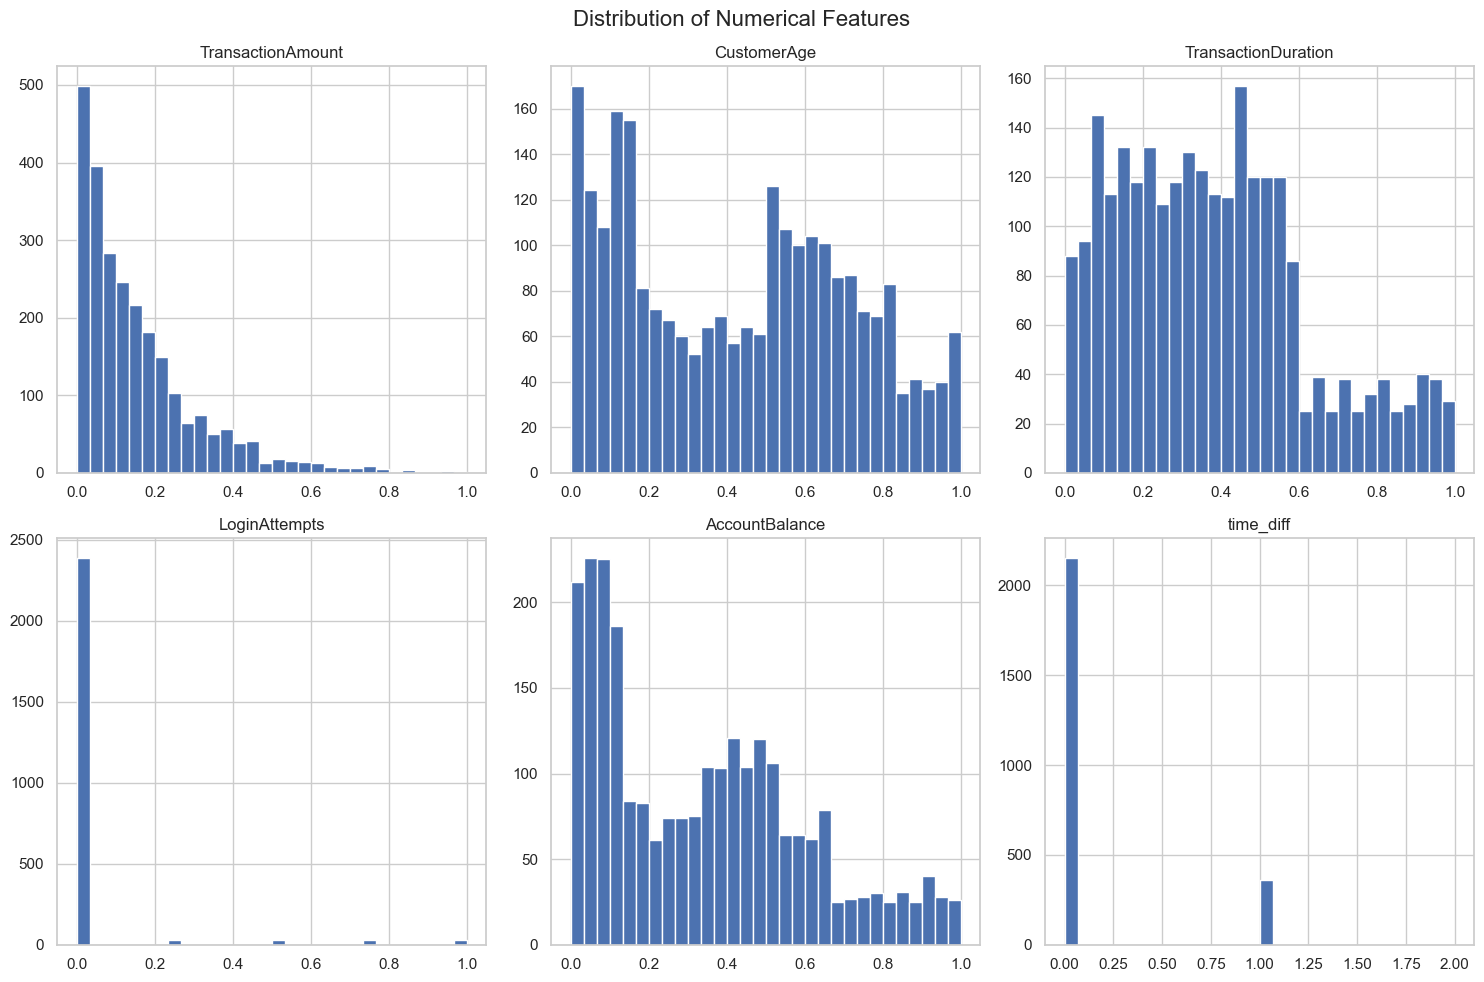

In [98]:
num_cols = ['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'LoginAttempts', 'AccountBalance', 'time_diff']
df[num_cols].hist(bins=30, figsize=(15, 10), layout=(2, 3))
plt.suptitle("Distribution of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

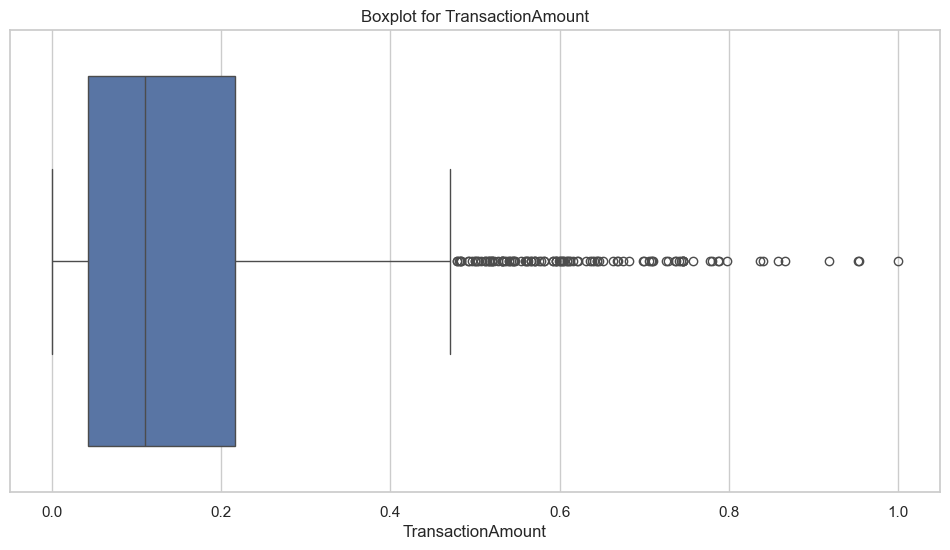

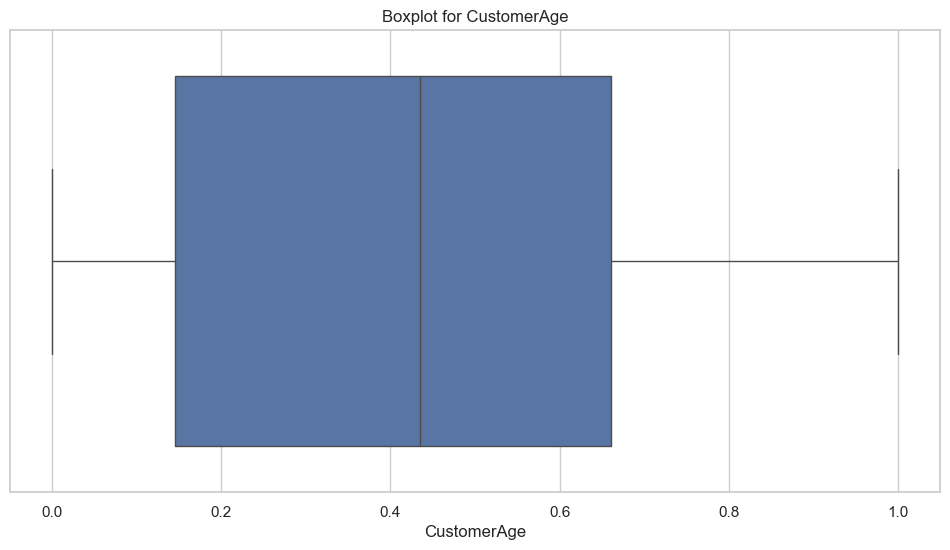

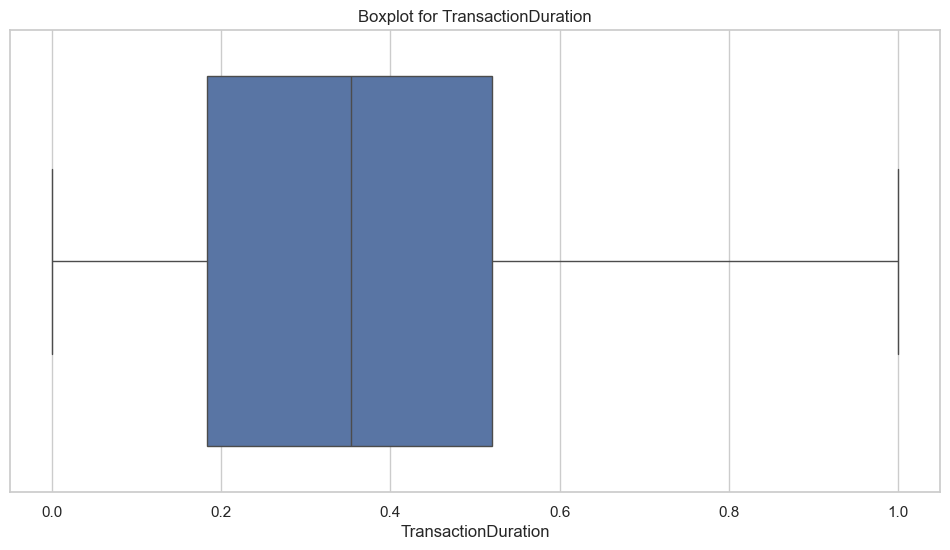

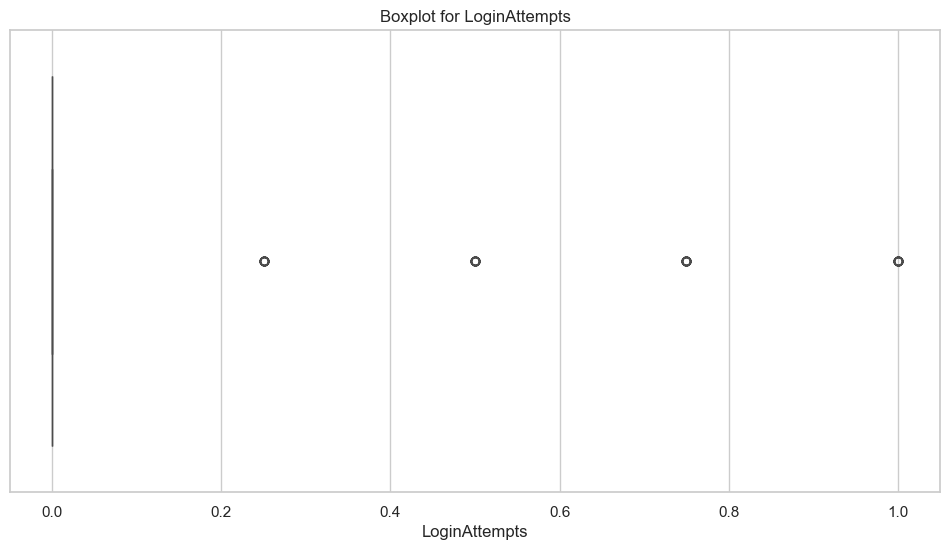

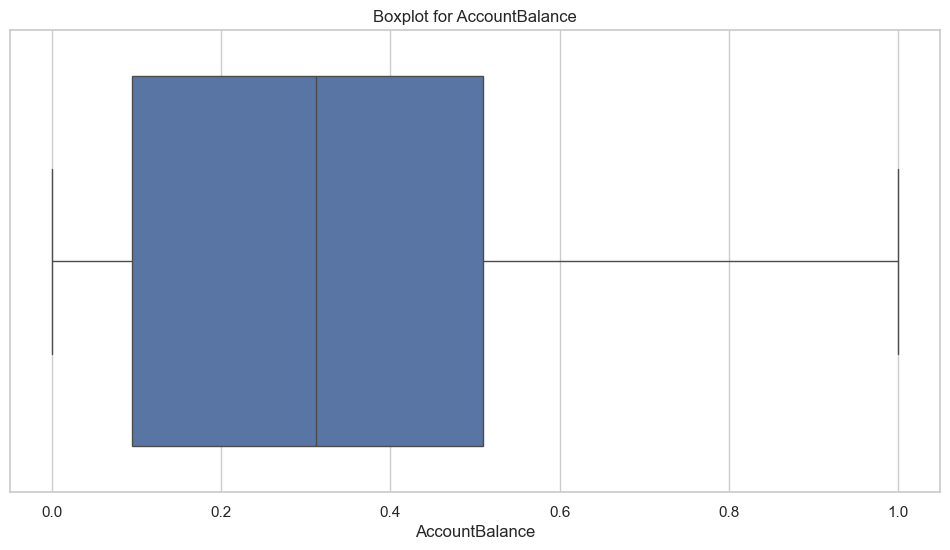

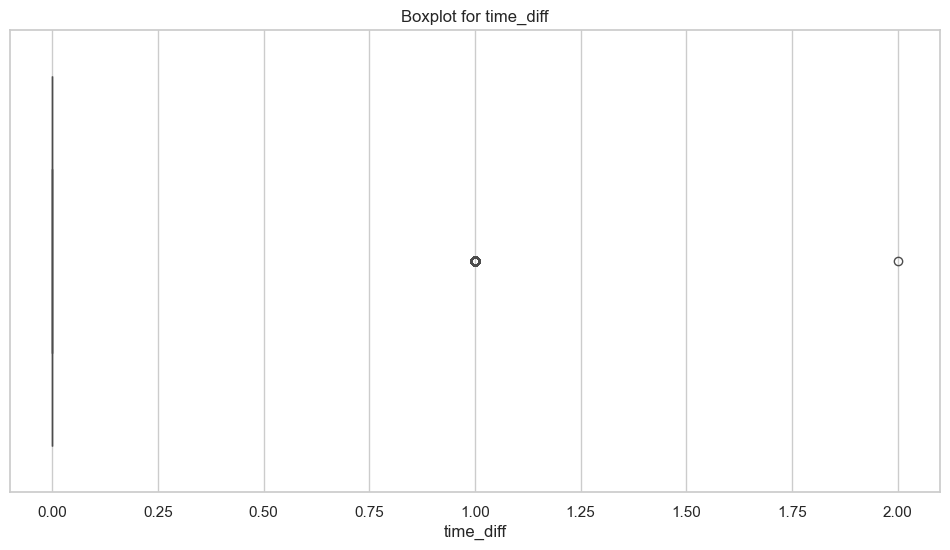

In [99]:
for col in num_cols:
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot for {col}")
    plt.show()

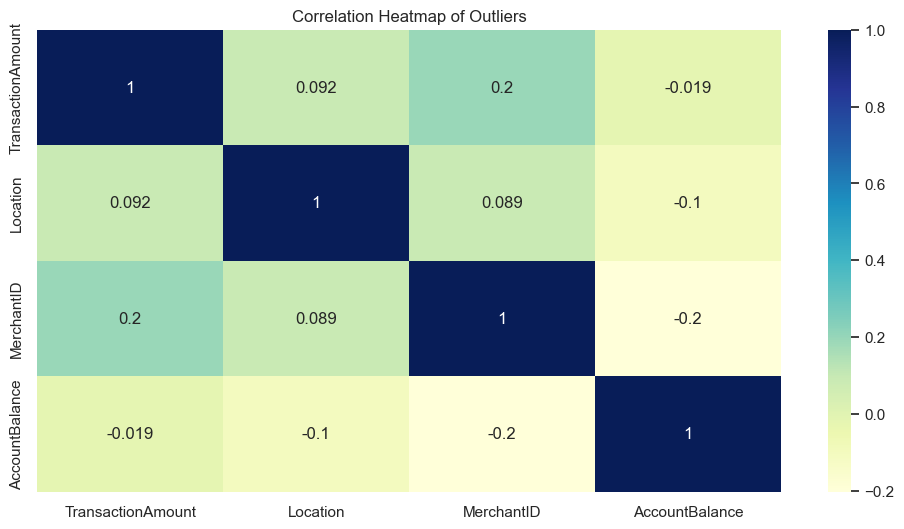

In [100]:
Q1 = df['TransactionAmount'].quantile(0.25)
Q3 = df['TransactionAmount'].quantile(0.75)
IQR = Q3 - Q1
threshold = Q3 + 1.5 * IQR

outliers = df[df['TransactionAmount'] > threshold][['TransactionAmount', 'Location', 'MerchantID', 'AccountBalance']]

outliers_scaled = outliers.copy()
outliers_scaled[['Location', 'MerchantID', 'AccountBalance']] = outliers_scaled[['Location', 'MerchantID', 'AccountBalance']].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

sns.heatmap(outliers_scaled.corr(), annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap of Outliers")
plt.show()

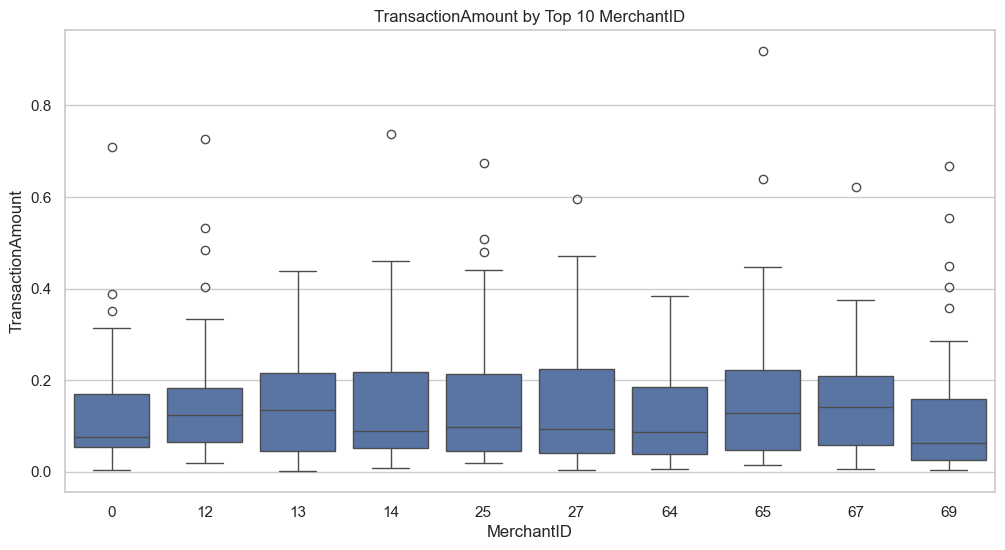

In [101]:
top_merchants = df['MerchantID'].value_counts().head(10).index
df_top_merchants = df[df['MerchantID'].isin(top_merchants)]
sns.boxplot(data=df_top_merchants, x='MerchantID', y='TransactionAmount')
plt.title("TransactionAmount by Top 10 MerchantID")
plt.show()

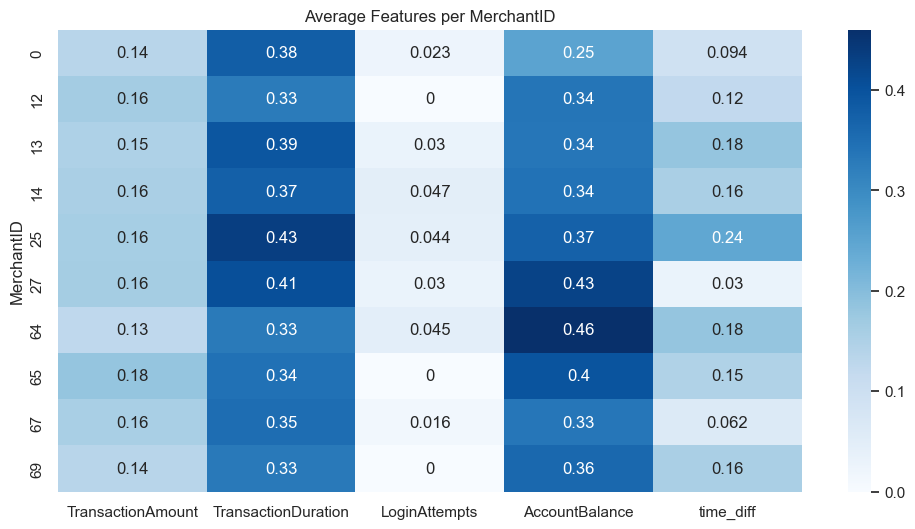

In [102]:
merchant_features = ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance', 'time_diff']
merchant_heatmap_data = df[df['MerchantID'].isin(top_merchants)].groupby('MerchantID')[merchant_features].mean()
sns.heatmap(merchant_heatmap_data, annot=True, cmap="Blues")
plt.title("Average Features per MerchantID")
plt.show()

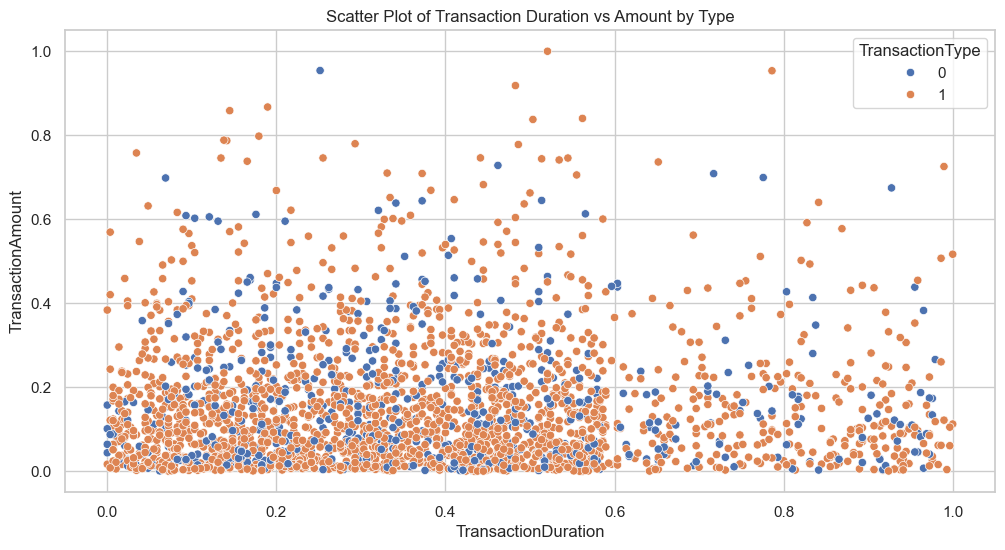

In [103]:
sns.scatterplot(data=df, x='TransactionDuration', y='TransactionAmount', hue='TransactionType')
plt.title("Scatter Plot of Transaction Duration vs Amount by Type")
plt.show()

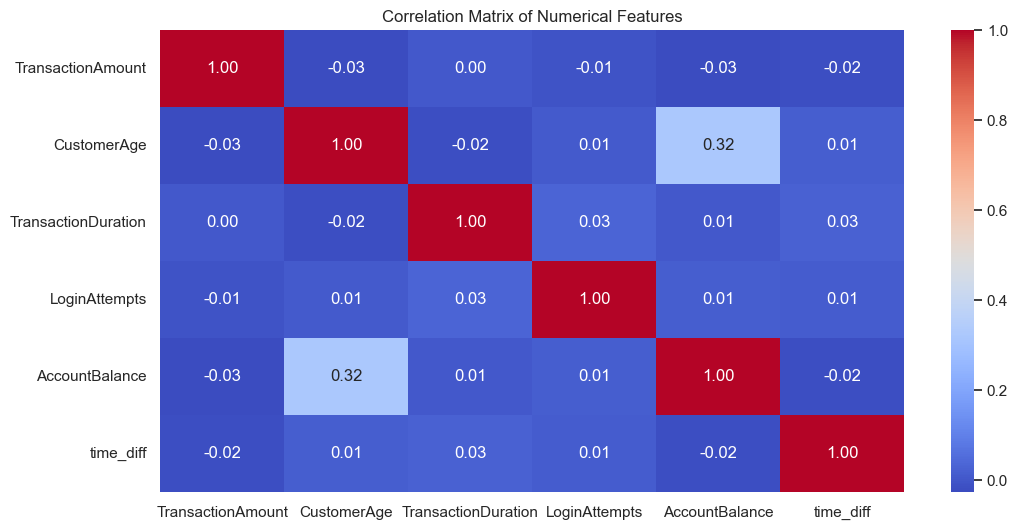

In [104]:
corr_matrix = df[num_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

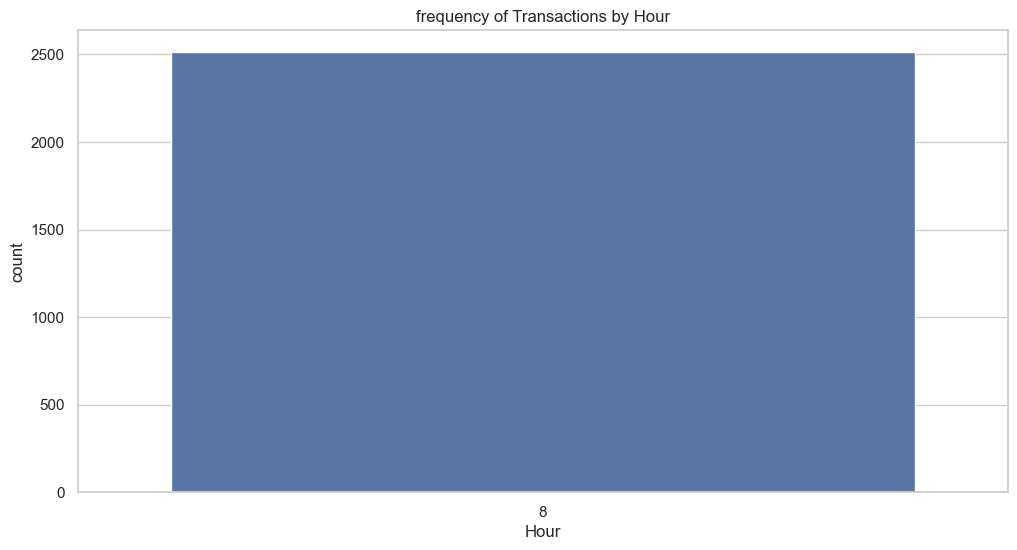

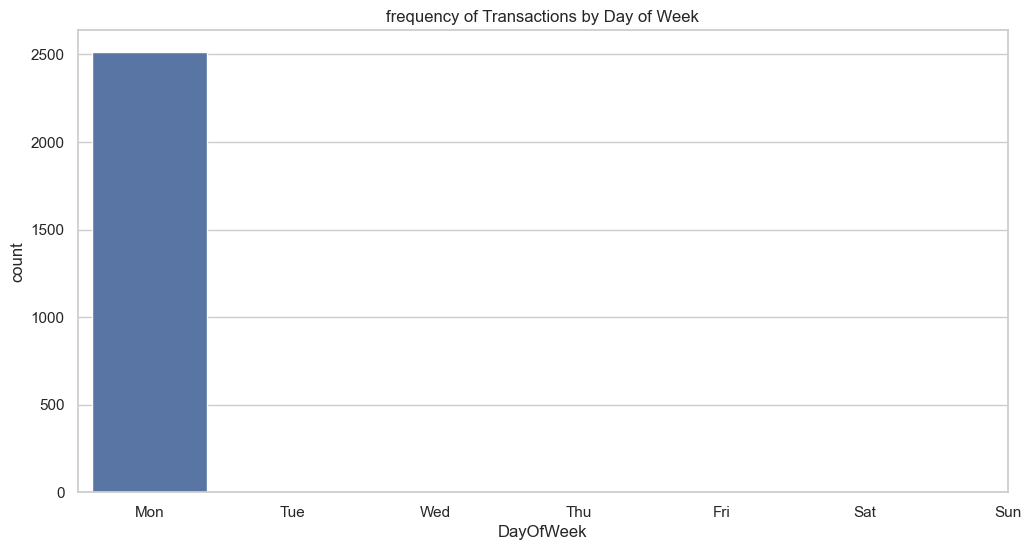

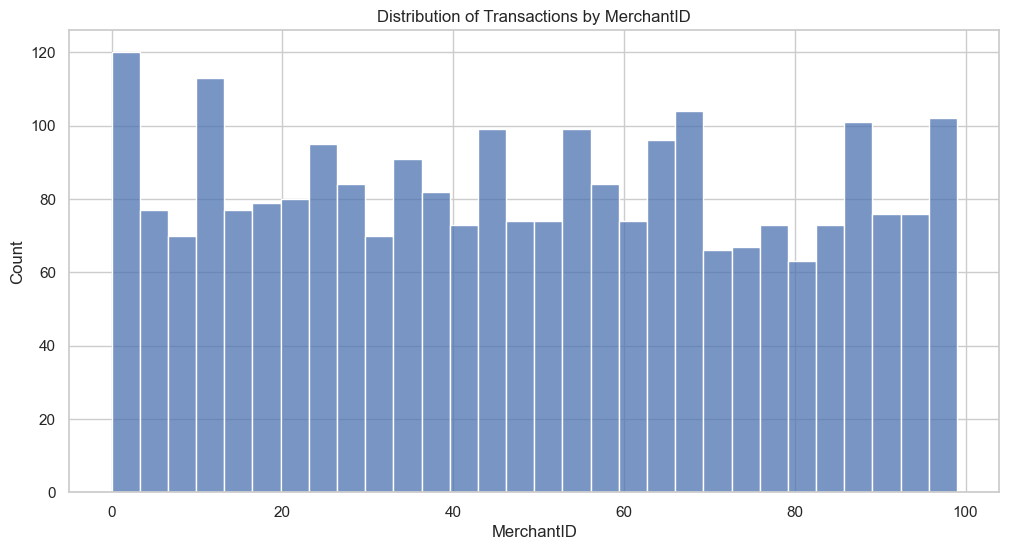

In [105]:
sns.countplot(x='Hour', data=df)
plt.title("frequency of Transactions by Hour")
plt.show()

sns.countplot(x='DayOfWeek', data=df)
plt.title("frequency of Transactions by Day of Week")
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

sns.histplot(data=df, x='MerchantID', bins=30)
plt.title("Distribution of Transactions by MerchantID")
plt.show()

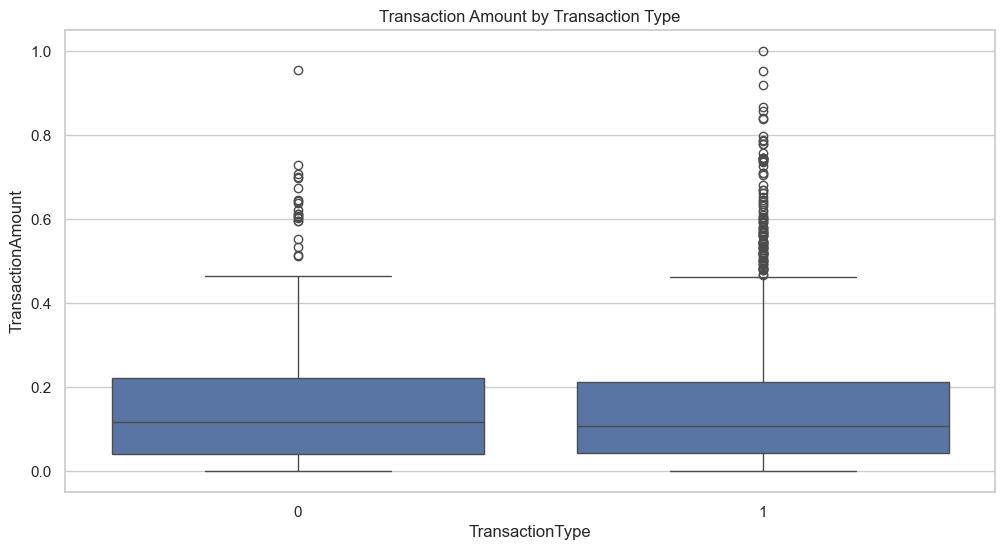

In [106]:
sns.boxplot(data=df, x='TransactionType', y='TransactionAmount')
plt.title("Transaction Amount by Transaction Type")
plt.show()

In [107]:
suspicious_merchants = [25, 27, 65, 13]
df['high_amount_flag'] = (df['TransactionAmount'] > 0.45).astype(int)
df['many_login_attempts_flag'] = (df['LoginAttempts'] > 0).astype(int)
df['long_time_diff_flag'] = (df['time_diff'] > 1).astype(int)
df['amount_to_balance_ratio'] = df['TransactionAmount'] / (df['AccountBalance'] + 1e-5)
df['amount_exceeds_balance'] = (df['amount_to_balance_ratio'] > 1).astype(int)
df['suspicious_merchant_flag'] = df['MerchantID'].isin(suspicious_merchants).astype(int)
df['reactivation_suspect_flag'] = ((df['long_time_diff_flag'] == 1) & (df['high_amount_flag'] == 1)).astype(int)
df['duration_suspicious_flag'] = (df['TransactionDuration'] > 0.8).astype(int)
df['age_balance_anomaly_flag'] = ((df['CustomerAge'] < 0.2) & (df['AccountBalance'] > 0.7)).astype(int)

In [108]:
flags = ['high_amount_flag', 'many_login_attempts_flag', 'suspicious_merchant_flag', 'reactivation_suspect_flag', 'amount_exceeds_balance']
df['strong_anomaly_label'] = df[flags].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

In [109]:
df.to_csv('../data/clean_transactions_with_flags.csv', index=False)